In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import data_preprocessing as dprep
import train_test as tt

DATA_PATH = 'data/dataset_mood_smartphone.csv'

In [2]:
# #################################### LOAD DATA #########################################
# data, ids, variables = dprep.load_data(DATA_PATH)

# ############################ GET STATISTICS AND CLEAN DATA ###############################
# data = dprep.remove_5(data, variables)
# table = dprep.stats(data, variables)
# table2 = dprep.stats(data, variables) 


# ########################## GROUP DATA BY PACIENT, DAY, VARIABLE ###############################    
# data_call_sms = data.loc[~data['variable'].isin(['mood','activity','circumplex.arousal','circumplex.valence'])].groupby(['id','time','variable']).sum().reset_index()
# data_else = data.loc[data['variable'].isin(['mood','activity','circumplex.arousal','circumplex.valence'])].groupby(['id','time','variable']).mean().reset_index()
# data = pd.concat([data_call_sms,data_else]).sort_values(by = ['id','time','variable'])

# ################################ DEALING WITH MISSING DATA ################################### 
# data =  dprep.fill_missing_data(data, ids, variables)
# data.to_csv(path_or_buf = 'data/data.csv')


# ###################### REMOVE DAYS WITH NO RELEVANT DATA(SPARSE DATA) #########################
# data = pd.crosstab(index = [data['id'],data['time']], 
#                    columns = data['variable'], values = data['value'], 
#                    aggfunc = lambda x:x).reset_index()

# # Swap 3rd column with mood, so later mood is the first column
# columns_new = data.columns.values.copy() 
# columns_new[2], columns_new[18] = columns_new[18], columns_new[2]
# data = data[columns_new]

# data = dprep.remove_days(data,ids)
# data.to_csv(path_or_buf = 'data/data.csv')

In [3]:
data, ids, variables = dprep.load_data(DATA_PATH)
data = pd.read_csv('data/data.csv',index_col=0)

In [4]:
################################## CORRELATION MATRXIX ####################################
total_corr, pacient_corr, pacient_mood_corr = dprep.correlation(data,ids)

####################### INDIVIDUALIZE DATA AND REMOVE INDIVIDUAL NaN DIMS ######################
pacients_original = dprep.individualize(data, ids, pacient_mood_corr)


#################################### STANDARDIZATION #########################################
mean_var = set(['activity','circumplex.arousal','circumplex.valence', 'time','id'])
pacients_standardized = dprep.standardization(pacients_original, ids, mean_var)



######################################## PCA ##############################################
pacients_pca = dprep.pca(pacients_standardized,ids)

In [226]:
##############################  Tests ###########################
    
X_train, Y_train, X_test, Y_test = tt.train_test_pca(pacients_pca,
                                                     pacients_original, 
                                                     ids, 
                                                     0.6)

_, _, X_test_orig, _ = tt.train_test_individual_pacient(pacients_original,
                                         pacients_original, 
                                         ids, 
                                         0.6)


X_train_all, Y_train_all, X_test_all, Y_test_all = tt.train_test_all(X_train, Y_train, X_test, Y_test, ids)

In [223]:

X_train, Y_train, X_test, Y_test = tt.train_test_individual_pacient(pacients_minimal,
                                                     pacients_original, 
                                                     ids, 
                                                     0.6)
X_train_all, Y_train_all, X_test_all, Y_test_all = tt.train_test_all(X_train, Y_train, X_test, Y_test, ids)

-0.5729049940151265
-0.5752354445485282
-0.8552095595839942
-0.659221864335547
-0.8588460732912641
-2.0170511876434642
-0.5505125890992385
-0.5461447150960468
-0.5414863992259707
-0.5321470115646306
-0.5414740945128688
-0.5303329683902731
-1.2570342253564255
-1.147077313012105
-1.289242326648281
-0.617917726787784
Best algorithm is GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.0001, loss='lad', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=0,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


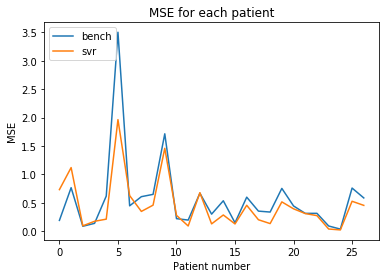

In [227]:
algorithm = algorithms[tt.choose_algorithm(X_train_all, Y_train_all)]
print(f"Best algorithm is {algorithm}")

bench_predictions = tt.benchmark(X_test_orig, ids, period = 3)
svr_predictions = tt.regression(algorithm,
                                X_train, Y_train, X_test,
                                X_train_all, Y_train_all, X_test_all, 
                                ids)

bench, bench_all = tt.prediction_stats(bench_predictions, Y_test, Y_test_all, ids)
svr,svr_all = tt.prediction_stats(svr_predictions, Y_test,Y_test_all,ids)


plt.figure()
plt.plot(bench, label = 'bench')
plt.plot(svr, label = 'svr')
plt.title('MSE for each patient')
plt.xlabel("Patient number")
plt.ylabel("MSE")
plt.legend(loc='upper left')
plt.show()


def plots(data1,variables):    
    for var in variables:
        values = list(data1.loc[data1['variable'] == var]['value'])
        plt.figure()
        plt.hist(values)        
        plt.savefig('plots/hist_' + var + '.png')

In [228]:
bench_all, svr_all

(0.5824862557942562, 0.5550090052611651)

In [318]:
importlib.reload(tt)

<module 'train_test' from '/Users/bogdan/Dropbox/uva/UvA/y2/s2/dm/MoodPrediction/train_test.py'>

In [290]:
pacients_minimal = {}
for k,v in pacients_standardized.items():
    pacients_minimal[k] = pacients_original[k][['mood', 'circumplex.valence']]
   
pacients_mood = {}
for k,v in pacients_standardized.items():
    pacients_mood[k] = pacients_standardized[k][['mood']]

In [303]:
X_train, Y_train, X_test, Y_test = tt.train_test_pca(pacients_pca,
                                                     pacients_original, 
                                                     ids, 
                                                     0.6,
                                                     period=3,
                                                     ravel=False)
X_train_all, Y_train_all, X_test_all, Y_test_all = tt.train_test_all(X_train, Y_train, X_test, Y_test, ids)
X_train_all.shape

(692, 3, 10)

In [305]:
X_train, Y_train, X_test, Y_test = tt.train_test_individual_pacient(pacients_minimal,
                                                     pacients_original, 
                                                     ids, 
                                                     0.6,
                                                     period=3,
                                                     ravel=False)
X_train_all, Y_train_all, X_test_all, Y_test_all = tt.train_test_all(X_train, Y_train, X_test, Y_test, ids)
X_train_all.shape

(692, 3, 2)

In [319]:
tt.lstm(X_train_all, Y_train_all, X_test_all, Y_test_all)

Train on 692 samples, validate on 437 samples
Epoch 1/200
 - 33s - loss: 9.5961 - val_loss: 0.7255
Epoch 2/200
 - 0s - loss: 0.6089 - val_loss: 0.5551
Epoch 3/200
 - 0s - loss: 0.5364 - val_loss: 0.5545
Epoch 4/200
 - 0s - loss: 0.5323 - val_loss: 0.5680
Epoch 5/200
 - 0s - loss: 0.5381 - val_loss: 0.5565
Epoch 6/200
 - 0s - loss: 0.5308 - val_loss: 0.5627
Epoch 7/200
 - 0s - loss: 0.5328 - val_loss: 0.5522
Epoch 8/200
 - 0s - loss: 0.5299 - val_loss: 0.5578
Epoch 9/200
 - 0s - loss: 0.5300 - val_loss: 0.5532
Epoch 10/200
 - 0s - loss: 0.5314 - val_loss: 0.5565
Epoch 11/200
 - 0s - loss: 0.5315 - val_loss: 0.5499
Epoch 12/200
 - 0s - loss: 0.5294 - val_loss: 0.5488
Epoch 13/200
 - 0s - loss: 0.5289 - val_loss: 0.5495
Epoch 14/200
 - 0s - loss: 0.5277 - val_loss: 0.5468
Epoch 15/200
 - 0s - loss: 0.5279 - val_loss: 0.5457
Epoch 16/200
 - 0s - loss: 0.5291 - val_loss: 0.5443
Epoch 17/200
 - 0s - loss: 0.5240 - val_loss: 0.5433
Epoch 18/200
 - 0s - loss: 0.5230 - val_loss: 0.5415
Epoch 19

0.39574804506531025